In [2]:
import os
import sys
import random

import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.append(os.path.join('..', '..', 'tta_uia_segmentation', 'src'))

from dataset.dataset_in_memory import get_datasets as get_datasets_without_nn  
from tta_uia_segmentation.src.models.io import load_norm_and_seg_from_configs_and_cpt
from tta_uia_segmentation.src.utils.io import load_config
from tta_uia_segmentation.src.dataset.utils import onehot_to_class, normalize_min_max
from tta_uia_segmentation.src.utils.visualization import plot_img_seg
from tta_uia_segmentation.src.utils.loss import dice_score, DescriptorRegularizationLoss 


min_max_norm_images = [-0.8531329035758972, 0.28733062744140625]

In [3]:
def plot_augmentations(img_idx, num_examples, norm, seg, ds):
    for _ in range(num_examples):
        img, seg_gt, *_ = ds[img_idx]

        img_norm = norm(img.unsqueeze(0))
        seg_pred, _ = seg(img_norm)
        
        plot_img_seg(
            img = img.squeeze().numpy(),
            img_title='Original Augmented Image',
            seg = onehot_to_class(seg_gt.unsqueeze(0)).squeeze().numpy(),
            seg_title='Ground Truth Augmented Segmentation',
            intensity_range=(0, 1)
        )
        
        reg_sift = reg_losses['sift']
        reg_zncc = reg_losses['zncc']
        
        plot_img_seg(
            img = img_norm.squeeze().numpy(),
            img_title='NN Normalized Augmented Image\n' + \
                f'SIFT: {reg_sift(img.unsqueeze(0), img_norm).item(): 0.2e}' + \
                f', ZNCC: {reg_zncc(img.unsqueeze(0), img_norm).item(): 0.2e}' + \
                f', SSIM: {reg_losses["ssim"](img.unsqueeze(0), normalize_min_max(img_norm, *min_max_norm_images)).item(): 0.2e}',
            seg = onehot_to_class(seg_pred).squeeze(),
            seg_title=f'Predicted Augmented Segmentation\n' + \
                f'Dice Score: {dice_score(seg_gt.unsqueeze(0), seg_pred)[1].item(): 0.2%}',
            intensity_range=min_max_norm_images
        ) 
        print('\n\n' + '-'*50 + '\n\n')

In [4]:
# Load Normalizer and Segmentation model
dataset_name        = 'hcp_t2'
split               = 'test'
vol                 = 7
seg_model_dir       = '/scratch_net/biwidl319/jbermeo/data/models/brain/segmentation/hcp_t1/no_bg_supp_norm_w_3x3_conv'
cpt_path            = f'/scratch_net/biwidl319/jbermeo/logs/brain/tta/baselines/dae_nicos_implementation/05_08/no_bg_supp_norm_w_3x3_conv_run_2/checkpoints/checkpoint_tta_hcp_t2_0{vol}.pth'
device              = 'cuda' if torch.cuda.is_available() else 'cpu' 

model_params        = load_config('/scratch_net/biwidl319/jbermeo/MastersThesisUIASegmentation/config/models.yaml')
dataset_params      = load_config('/scratch_net/biwidl319/jbermeo/MastersThesisUIASegmentation/config/datasets.yaml')
dataset_params      = dataset_params[dataset_name]

# Load normalization and segmentation model
norm, seg = load_norm_and_seg_from_configs_and_cpt(
    n_classes=dataset_params['n_classes'],
    model_params_norm=model_params['normalization_2D'],
    model_params_seg=model_params['segmentation_2D'],
    cpt_fp=cpt_path,
    device=device    
)     
norm.eval()
seg.eval()


/scratch_net/biwidl319/jbermeo/GNN-Domain-Generalization-main/net_scratch/conda_envs/tta_uia_seg/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


UNet(
  (encoder): Encoder(
    (blocks): ModuleList(
      (0): EncoderBlock(
        (double_conv): DoubleConv(
          (network): Sequential(
            (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
            (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (5): ReLU(inplace=True)
          )
        )
        (downsample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): EncoderBlock(
        (double_conv): DoubleConv(
          (network): Sequential(
            (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [5]:


# Load dataset with original preprocessed images (val)
(ds, )  = get_datasets_without_nn(
        splits          = [split],
        paths           = dataset_params['paths_processed'],
        paths_original  = dataset_params['paths_original'], 
        image_size      = (256, 256, 256),
        resolution_proc = dataset_params['resolution_proc'],
        dim_proc        = dataset_params['dim'],
        n_classes       = dataset_params['n_classes'],
        aug_params      = None,
        deformation     = None,
        load_original   = True,
        bg_suppression_opts = None
    )

In [6]:
vol, seg_vol_gt, *_ = ds[vol]


In [7]:
seg_vol_gt.shape

torch.Size([15, 256, 256, 256])

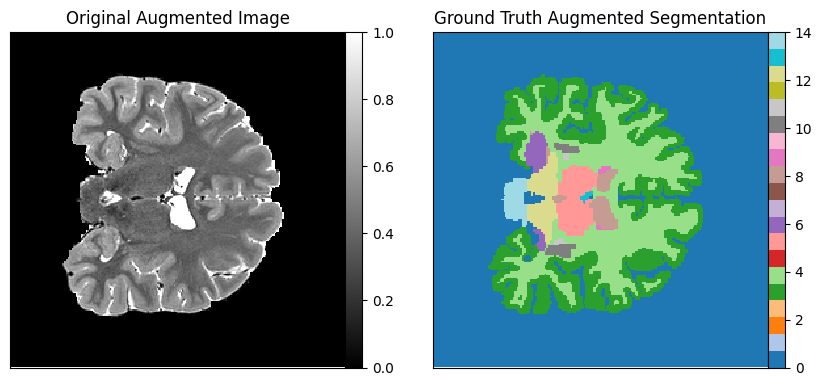

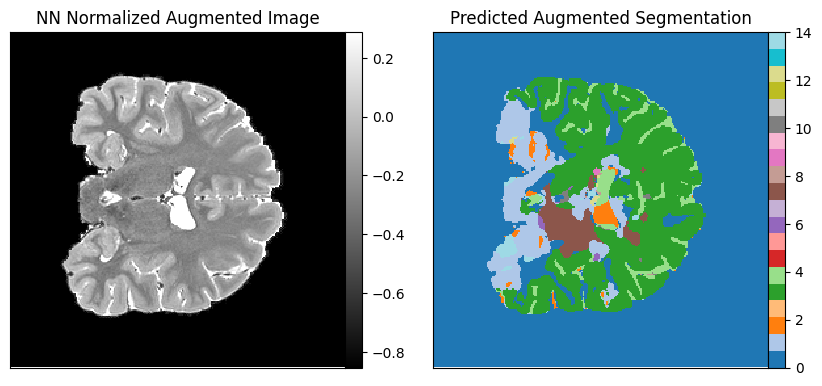

In [8]:
img = vol[128]
seg_gt = seg_vol_gt[:, 128]

with torch.no_grad():
    img_norm = norm(img.unsqueeze(0).unsqueeze(0))
    seg_pred, _ = seg(img_norm)

plot_img_seg(
    img = img.squeeze().numpy(),
    img_title='Original Augmented Image',
    seg = onehot_to_class(seg_gt.unsqueeze(0)).squeeze().numpy(),
    seg_title='Ground Truth Augmented Segmentation',
    intensity_range=(0, 1)
)

plot_img_seg(
    img = img_norm.squeeze().detach().numpy(),
    img_title='NN Normalized Augmented Image',
    seg = onehot_to_class(seg_pred).squeeze().detach().numpy(),
    seg_title='Predicted Augmented Segmentation',
    intensity_range=min_max_norm_images
)

In [9]:

img_norm

tensor([[[[-1.0006, -1.0006, -1.0006,  ..., -1.0006, -1.0006, -1.0006],
          [-1.0006, -1.0006, -1.0006,  ..., -1.0006, -1.0006, -1.0006],
          [-1.0006, -1.0006, -1.0006,  ..., -1.0006, -1.0006, -1.0006],
          ...,
          [-1.0006, -1.0006, -1.0006,  ..., -1.0006, -1.0006, -1.0006],
          [-1.0006, -1.0006, -1.0006,  ..., -1.0006, -1.0006, -1.0006],
          [-1.0006, -1.0006, -1.0006,  ..., -1.0006, -1.0006, -1.0006]]]])

In [20]:
onehot_to_class(seg_pred).shape

torch.Size([1, 1, 256, 256])